In [1]:
# Import library
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import h5py
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.models import resnet34
from torchsummary import summary
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve


In [2]:
path = '/Users/woojaejeong/Desktop/Program/USC/Computational Introduction to Deep Learning/Homeworks/HW7/data/'

transformation = torchvision.transforms.Compose([
    # Resize to 224 by 224
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
    # Data augmentation
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.99, 1.01)) # Scaling
])

batch_size = 100

image_data = torchvision.datasets.ImageFolder(root = path, transform = transformation)

dataset_size = len(image_data)
data_split = [0.7, 0.2, 0.1]

train_set, val_set, test_set = torch.utils.data.random_split(image_data, [round(p * len(image_data)) for p in data_split])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Replace final classification output-layer to 3 class
num_class = 3
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_class)

# Vanilla pretrained ResNet-34 model
model_v = resnet34(pretrained=True)
model_v.fc = nn.Linear(model_v.fc.in_features, num_class)

# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the new fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.fc.parameters(), lr = 1e-4)


/Users/woojaejeong/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/woojaejeong/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Trainng the model
num_epoch = 10
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epoch):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    total = 0

    if epoch == 2:
        for param in model.layer4.parameters():
            param.requires_grad = True
        
        optimizer = optim.Adam([
            {'params': model.layer4.parameters()},
            {'params': model.fc.parameters()}], lr = 1e-5)

    elif epoch == 4:
        for param in model.layer3.parameters():
            param.requires_grad = True
        
        optimizer = optim.Adam([
            {'params': model.layer3.parameters()},
            {'params': model.fc.parameters()}], lr = 1e-6)

    elif epoch == 6:
        for param in model.layer2.parameters():
            param.requires_grad = True
        
        optimizer = optim.Adam([
            {'params': model.layer2.parameters()},
            {'params': model.fc.parameters()}], lr = 1e-7)

    elif epoch == 8:
        for param in model.layer1.parameters():
            param.requires_grad = True
        
        optimizer = optim.Adam([
            {'params': model.layer1.parameters()},
            {'params': model.fc.parameters()}], lr = 1e-8)

    for i, (inputs, labels) in enumerate(train_loader):
        # Forward
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        train_correct += torch.sum(preds == labels.data)
        total += len(labels)
        
    train_loss = np.append(train_loss, train_running_loss / len(train_loader))
    train_acc = np.append(train_acc, 100 * train_correct.double() / total)
    
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(val_loader):
        with torch.no_grad():
            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            val_correct += torch.sum(preds == labels.data)
            total += len(labels)

    val_loss = np.append(val_loss, val_running_loss / len(val_loader))
    val_acc = np.append(val_acc, 100 * val_correct.double() / total)


/Users/woojaejeong/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


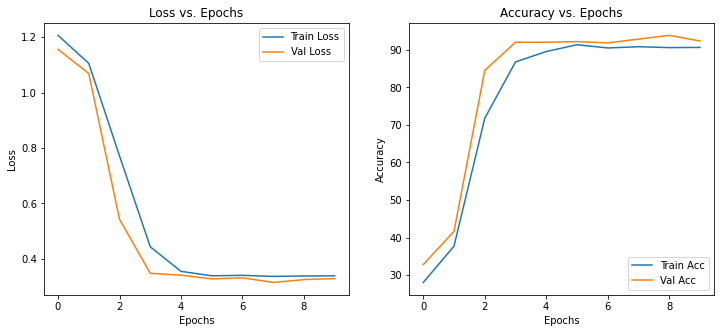

I unfreezed each layer starting from the layer 4 to layer 1 after every 2 epochs


In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('I unfreezed each layer starting from the layer 4 to layer 1 after every 2 epochs')

/Users/woojaejeong/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


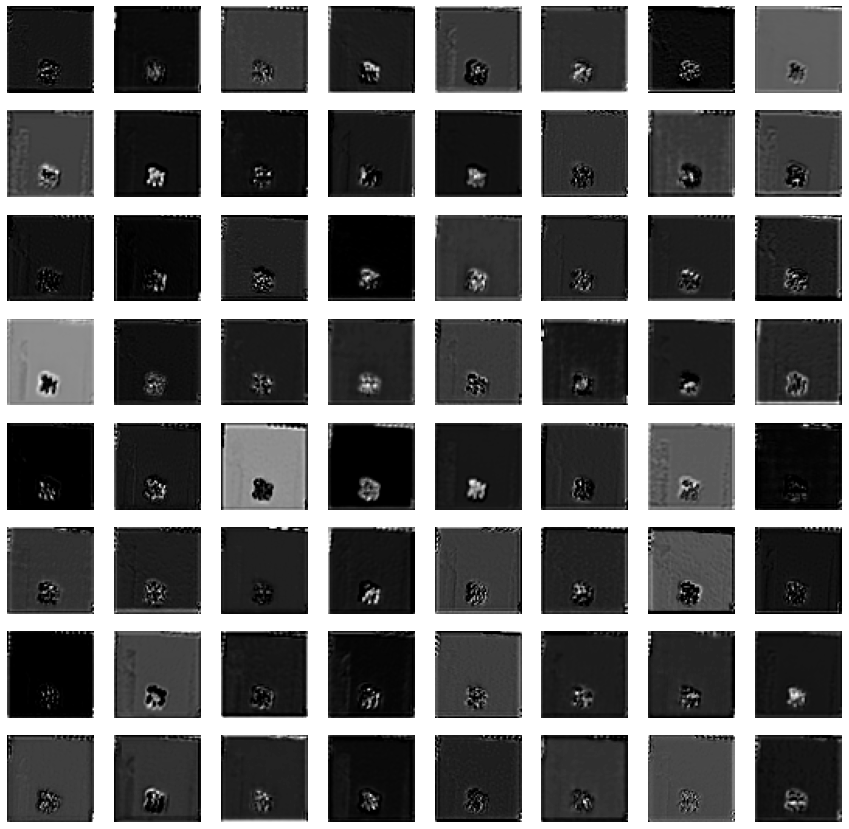

Layer 1 visualization


In [42]:
single_loader = torch.utils.data.DataLoader(image_data, batch_size = 1)

image, _ = next(iter(single_loader))

def visualize_hook(module, input, output):
    plt.figure(figsize = (15,15))
    for i in range(output.size(1)):
        plt.subplot(8,8,i+1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    
    plt.show()

def visualize_hook2(module, input, output):
    plt.figure(figsize = (15,15))
    for i in range(output.size(1)):
        plt.subplot(16,16,i+1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    
    plt.show()

def remove_hook(model):
    for module in model.modules():
        module._forward_hooks.clear()
        module._backward_hooks.clear()

remove_hook(model)

layer_to_visualize = model.layer1
hook = layer_to_visualize.register_forward_hook(visualize_hook)

_, = model(image)

print('Layer1 visualization')

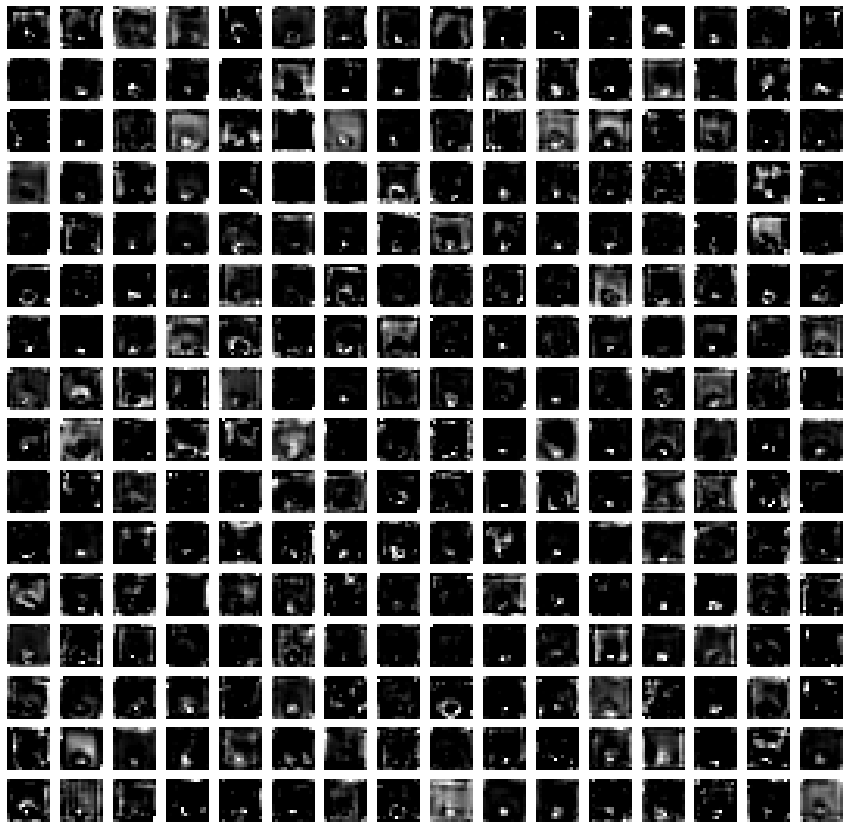

Layer3 visualization


In [43]:
remove_hook(model)

layer_to_visualize = model.layer3
hook = layer_to_visualize.register_forward_hook(visualize_hook2)

_, = model(image)

remove_hook(model)
print('Layer3 visualization')

In [47]:
# Vanilla pretrained ResNet-34 model
model_v.eval()

test_running_loss = 0.0
test_correct = 0
total = 0 

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward
        outputs = model_v(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        test_correct += torch.sum(preds == labels.data)
        total += len(labels)

test_loss_vanilla = test_running_loss / len(test_loader)
test_acc_vanilla = 100 * test_correct.double() / total

# Fine-tuned ResNet-34 model

model.eval()

test_running_loss = 0.0
test_correct = 0
total = 0 

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        test_correct += torch.sum(preds == labels.data)
        total += len(labels)

test_loss= test_running_loss / len(test_loader)
test_acc = 100 * test_correct.double() / total


/Users/woojaejeong/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [48]:
print('The accuracy of the fine-tuned model is:',test_acc.item())
print('The accuracy of the vanilla pretrained model is:',test_acc_vanilla.item())

The accuracy of the fine-tuned model is: 93.0
The accuracy of the vanilla pretrained model is: 38.666666666666664


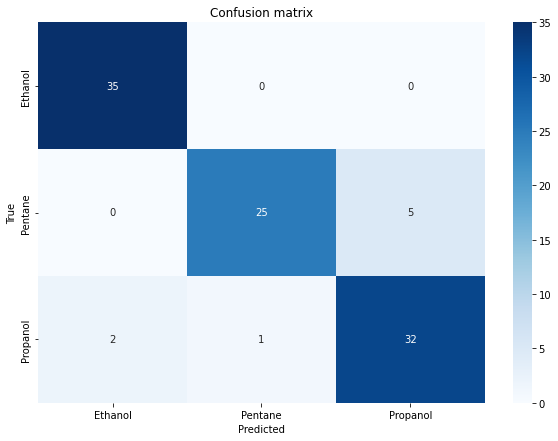

In [49]:
# Confusion matrix
preds_c = preds.cpu().numpy()
labels_c = labels.cpu().numpy()

cm = confusion_matrix(labels_c, preds_c)

class_names = ['Ethanol','Pentane','Propanol']
df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)

plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, cmap = 'Blues', fmt ='g')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

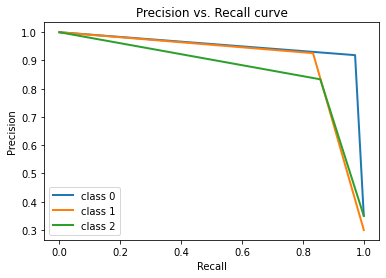

In [36]:
all_labels = np.array(labels)
all_preds = np.array(preds)

all_labels_binarized = preprocessing.label_binarize(all_labels, classes = range(num_class))

precision = dict()
recall = dict()

for i in range(num_class):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_binarized[:, i], all_preds == i)

for i in range(num_class):
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()